# Optimization techniques Lab. 5: Iterated local Search and Simulated Annealing
## Introduction
**Goal.** The goal of this lab is to compare the behavior of Iterated Local search (ILS) and Simulated Annealing on the knapsack 0/1 problem and/or on the Flowshop problem.

**Getting started.** The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities.

## The Knapsack 0/1 problem
The knapsack 0/1 problem is a combinatorial problem that works as follows.

We have a bag with limited capacity L, and we have a set of items $I = {i_1, ..., i_N}$
Each $i_j$ has a given volume $w_{i_j}$ and a value $v_{i_j}$.
The goal of the optimization problem is to fill the bag with a combination of items $S$ such that the combination maximizes the total value contained by the bag while complaining with the constraint on the capacity.

In this version of the knapsack problem we can either discard or carry (at most 1) item. Thus, the search space is $\{0, 1\}^{|I|}$.

Since this is a maximization problem, we can turn it into a minimization problem by returning the opposite of the value.
If a solution is not feasible (i.e., exceeds the maximum volume) the function will return a score of 0 (like an empty bag).

## The Flowshop Problem
The flow-shop problem is a scheduling problem, where $m$ machines execute $p$ processes. 

The order to execute the process is the same in every machine. However, machine $m_j$ can not execute the $p_i$ process before it is completed in the $m_{j-1}$ machine. 

The object is to minimize the makespan time which is the time between the start of the first process and the end of the last process. 
The $m$ machines execute the $p$ process in the same order. Hence, a solution $s$ is a vector that indicates the execution order.  

In [6]:
import numpy as np
from matplotlib import pyplot as plt

class Knapsack_0_1:
    
    def __init__(self):
        self._items = [
            {'name': 'apple', 'value': 1, 'volume': 2},    
            {'name': 'pear', 'value': 2, 'volume': 2},    
            {'name': 'banana', 'value': 2, 'volume': 2},    
            {'name': 'watermelon', 'value': 5, 'volume': 10},    
            {'name': 'orange', 'value': 3, 'volume': 2},    
            {'name': 'avocado', 'value': 3, 'volume': 2},    
            {'name': 'blueberry', 'value': 3, 'volume': 1},    
            {'name': 'coconut', 'value': 4, 'volume': 3},    
            {'name': 'cherry', 'value': 2, 'volume': 1},    
            {'name': 'apricot', 'value': 1, 'volume': 1},      
        ]
        self._BAG_CAPACITY = 10
        self.history = []
        self.values = []

    def _get_value(self, solution):
        cur_cap = self._BAG_CAPACITY
        cur_val = 0
        for i, v in enumerate(solution):
            if v == 1:
                cur_val += self._items[i]['value']
                cur_cap -= self._items[i]['volume']
            if cur_cap < 0:
                return 0
        return -cur_val

    def __call__(self, solution):
        value = self._get_value(solution)
        self.history.append(solution)
        self.values.append(value)
        return value
    
    def trend(self):
        plt.figure()
        plt.plot(self.values)
        plt.show()

class Flowshop:
    
    def __init__(self, machine, process, processing_time = None):
        self._items = [
                        []   
        ]
        self.machine = machine
        self.process = process
        self.p = processing_time if not processing_time is None else np.random.randint(0, 20, size= (machine, process))

        self.history = []
        self.values = []

    def _get_value(self, solution):
        f = np.zeros((self.machine, self.process), dtype=int)
        for m in range(self.machine):
            for p in range(self.process):
                sp = solution[p] #solution at p
                spp = solution[p-1] if p>0 else None #solution at p-1 if exist
                if m == 0 and p == 0:
                    f[m,sp] = self.p[m, sp]
                elif m == 0:
                    f[m,sp] = f[m, spp] + self.p[m, sp]
                elif p == 0:
                    f[m,sp] = f[m-1, sp] + self.p[m, sp]
                else:
                    f[m,sp] = max(f[m-1, sp], f[m, spp]) + self.p[m, sp]
        return max(f.flatten())

    def __call__(self, solution):
        value = self._get_value(solution)
        self.history.append(solution)
        self.values.append(value)
        return value
    
    def trend(self):
        plt.figure()
        plt.plot(self.values)
        plt.show()

In [16]:
from operator import index
from random import randint

def ils(f, x0, ls_max):
    """
    Seeks for the minimum of the function by means of the Iterated local search algorithm.

    :f: the function to optimize
    :x0: the initial point
    :ls_max: the max number of local search
    """

    def perturbation(x, k):
    # To be implemented
        """
        Implementation of the perturbation function (K-opt move)
        """
        for i in range(k):
            index1, index2  = randint(0,len(x)-1), randint(0,len(x)-1)
            x[index1], x[index2] = x[index2], x[index1]
        return x


    def acceptance_criterion(f, x, xs, k):
        if f(xs) < f(x):
            x = xs
            k = 1
        else:
            k += 1
        return x, k

    def local_search(f, x):
        # To be implemented
        """
        implementation of the local search on the knapsack problem
        """
        x[randint(0,len(x)-1)] = randint(0,1)
        return x
        

    n = 0
    x = np.array(x0, float)
    best = x
    bestval = f(x)
    
    i = 0
    while i < ls_max:
        xp = perturbation(x, i)
        xs = local_search(f, xp)
        x, i = acceptance_criterion(f, x, xs, i)
        
        # Store the best
        curval = f(x)
        if curval < bestval:
            bestval = curval
            best = x
        print("Iteration: ", n, "Best value: ", bestval)
    return best

def sa(f, x0, T, k, alpha):
    """
    Seeks for the minimum of the function by means of the Simulated Annealing algorithm.

    :f: the function to optimize
    :x0: the initial point
    :T: Initial high temperature
    :k: Number of Iterations
    """
    def random_neighbor(x, i):
        """
        Generates and selects a random neighobor for the solution x.
        """
        return x
    
    def acceptance(x, e, xp, ep):
        """
        Returns the solution and fitness accepted between x and xp.
        """
        return x, e

    def update_temperature(T, alpha):
        """
        Updates the temperature T and the parameter alpha.
        """
        return T, alpha

    x = np.array(x0)
    for i in range(k):
        e = f(x)
        xp = random_neighbor(x, i)
        ep = f(xp)
        x, e = acceptance(x, e, xp, ep)
        T, alpha = update_temperature(T, alpha)

    return x, e

# iterated Local Search
---
## Questions:
- how does the starting point influence the search process?
- how does the ls_max parameter affect the quality of the result?
- how does the perturbation of the solutions affect:
    - quality of the search?
    - velocity of the search?

Iteration:  0 Best value:  0
Iteration:  0 Best value:  0
Iteration:  0 Best value:  -2
Iteration:  0 Best value:  -5
Iteration:  0 Best value:  -5
Iteration:  0 Best value:  -6
Iteration:  0 Best value:  -6
Iteration:  0 Best value:  -6
Iteration:  0 Best value:  -6
Iteration:  0 Best value:  -6


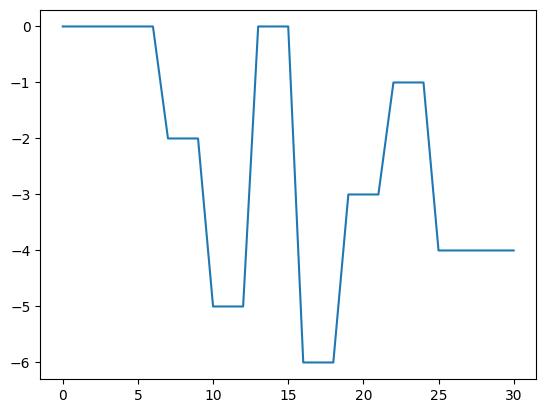

In [20]:
func = Knapsack_0_1()
ils(func, [0] * len(func._items), 10)
func.trend()

# Simulated Annealing Search
---
## Questions:
- how does the starting point influence the search process?
- how does the initial temperature affect the quality of the result?
- how does the selection of the neighborhood affect:
    - quality of the search?
    - velocity of the search?
- How does the acceptance policy influence the search?
- How does the update of the temparture affect the search?

In [ ]:
func = Knapsack_0_1()
sa(func, [0] * len(func._items), 1, 1, 0.1)
func.trend()

Iterated local search, variable neighbor search, and simulated annealing are very similar optimization algorithms. 
Considering what was seen in this lab and the previous one, answer these questions:
 - Is there a "more efficient" algorithm?
 - How do the different parameters affect the search, and do they affect the choice of one algorithm to respect the others?